In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.35
tf.Session(config=config)

import keras
from keras.models import Model
from keras.layers import (Dense, Dropout, Flatten, Input, Conv2D, 
                          MaxPooling2D, Activation, BatchNormalization,
                          GlobalMaxPooling2D, Lambda)
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import tf as ktf
from keras.callbacks import EarlyStopping
from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import csv
import os
from PIL import Image
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style()

### Data pipeline

In [3]:
X_train = np.load('data/processed/X_train.npy')
Y_train = np.load('data/processed/Y_train.npy')
X_test = np.load('data/processed/X_test.npy')

# train_data = np.load('models/bottleneck_features_train.npy')
# validation_data = np.load('models/bottleneck_features_validation.npy')
# test_data = np.load('models/bottleneck_features_test.npy')

In [4]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.10, random_state=0)

In [58]:
print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape)

(9199, 128, 128, 3) (9199, 120)
(1023, 128, 128, 3) (1023, 120)
(10357, 128, 128, 3)


In [5]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,        
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,    
    zoom_range = 0.2,
    fill_mode='nearest')

test_datagen = ImageDataGenerator()

In [8]:
batch_size = 16
train_generator = train_datagen.flow(X_train, Y_train)
dev_generator = train_datagen.flow(X_dev, Y_dev)

### VGG as base model

In [39]:
def vggModel():
    base_model = VGG16(weights='imagenet', include_top=False, 
                         input_shape=(128, 128, 3), classes=1)
    X = base_model.get_layer('block5_pool').output
    X = GlobalMaxPooling2D()(X)
#     X = Conv2D(512, (3, 3), activation='relu')(X)
#     X = MaxPooling2D((3, 3))(X)
#     X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
#     X = Dense(1024, activation='relu')(X)
#     X = Dropout(0.2)(X)
#     X = Dense(256, activation='relu')(X)
#     X = Dropout(0.2)(X)
    predictions = Dense(120, activation='softmax')(X)
    
    model = Model(inputs=base_model.input, outputs=predictions)
        
    for layer in base_model.layers:
        layer.trainable = False
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

    print(model.summary())
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model
    

In [40]:
model2 = vggModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [41]:
callbacks_list = [EarlyStopping(monitor='val_acc', patience=3, verbose=1)]


In [42]:
history = model2.fit_generator(
                    train_generator,
                    steps_per_epoch= X_train.shape[0] // batch_size,
                    epochs=50,
                    validation_data=dev_generator,
                    validation_steps=X_dev.shape[0] // batch_size,
                    callbacks=callbacks_list)

Epoch 1/50
574/574 [==============================] - 218s 380ms/step - loss: 4.7320 - acc: 0.0173 - val_loss: 4.6185 - val_acc: 0.0313
Epoch 2/50
574/574 [==============================] - 213s 370ms/step - loss: 4.4702 - acc: 0.0423 - val_loss: 4.3462 - val_acc: 0.0615
Epoch 3/50
574/574 [==============================] - 212s 369ms/step - loss: 4.2578 - acc: 0.0647 - val_loss: 4.1968 - val_acc: 0.0849
Epoch 4/50
574/574 [==============================] - 211s 368ms/step - loss: 4.1391 - acc: 0.0762 - val_loss: 4.0919 - val_acc: 0.0988
Epoch 5/50
574/574 [==============================] - 209s 364ms/step - loss: 4.0674 - acc: 0.0824 - val_loss: 4.0285 - val_acc: 0.1012
Epoch 6/50
574/574 [==============================] - 205s 358ms/step - loss: 4.0347 - acc: 0.0885 - val_loss: 3.9937 - val_acc: 0.1122
Epoch 7/50
574/574 [==============================] - 205s 357ms/step - loss: 3.9973 - acc: 0.0961 - val_loss: 3.9777 - val_acc: 0.1032
Epoch 8/50
574/574 [============================

KeyboardInterrupt: 

In [21]:
print(history.history.keys())


dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


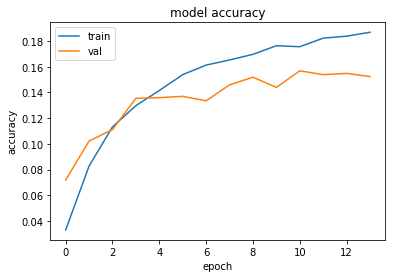

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


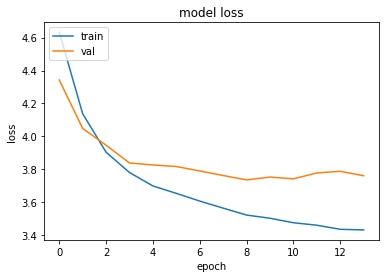

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
preds = model2.predict(X_test, verbose=1, batch_size=16)

10357/10357 [==============================] - 83s 8ms/step


In [38]:
model2.save_weights('models/vgg16-es-14epochs-1fc.h5')

In [103]:
preds.shape

(10357, 120)

In [33]:
df_train = pd.read_csv('labels.csv')
df_test = pd.read_csv('sample_submission.csv')
one_hot = pd.get_dummies(df_train['breed'], sparse = True)

sub = pd.DataFrame(preds)
sub.columns = one_hot.columns.values
sub.insert(0, 'id', df_test['id'])

sub.to_csv('sub.csv', index=False)

### Bottleneck feature extraction

In [6]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training and validation loss')
    plt.show()

In [60]:
vgg16model = VGG16(weights='imagenet', include_top=False)
train_data = vgg16model.predict(X_train, verbose=1)
validation_data = vgg16model.predict(X_dev, verbose=1)
# test_data = vgg16model.predict(X_test, verbose=1)
test_data = np.load('models/bottleneck_features_test.npy')

 992/9199 [==>...........................] - ETA: 46:10

KeyboardInterrupt: 

In [55]:
def top_model(input_shape):
    input_img = Input(input_shape)
    X = Flatten(input_shape=train_data.shape[1:])(input_img)
    X = Dropout(0.5)(X)
    
    
    X = Dense(1024, activation='relu')(X)
    
    X = Dense(120, activation='softmax')(X)
    
    model = Model(inputs=input_img, outputs=X)
    
    model.compile(loss='categorical_crossentropy',
                 optimizer='sgd',
                 metrics=['accuracy'])
    
    return model

In [35]:
from keras.applications.vgg16 import preprocess_input

In [46]:
# train_data_ = preprocess_input(train_data)
# validation_data_ = preprocess_input(validation_data)
train_data_ = train_data / np.max(train_data)

In [48]:
validation_data_ = validation_data / np.max(validation_data)

In [56]:
model2 = top_model(train_data.shape[1:])

In [57]:
history2 = model2.fit(train_data, Y_train, epochs=50, batch_size=100, verbose=1, validation_data=(validation_data, Y_dev), callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 24s 3ms/step - loss: 15.9991 - acc: 0.0072 - val_loss: 15.3462 - val_acc: 0.0088
Epoch 2/50
9199/9199 [==============================] - 8s 920us/step - loss: 15.9903 - acc: 0.0078 - val_loss: 15.3368 - val_acc: 0.0088
Epoch 3/50
9199/9199 [==============================] - 10s 1ms/step - loss: 15.9898 - acc: 0.0079 - val_loss: 15.3063 - val_acc: 0.0088
Epoch 4/50
9199/9199 [==============================] - 12s 1ms/step - loss: 15.9531 - acc: 0.0101 - val_loss: 15.2130 - val_acc: 0.0088
Epoch 00004: early stopping


## Plots

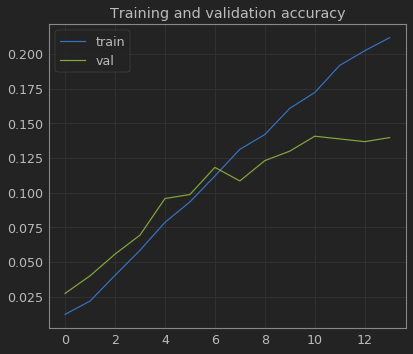

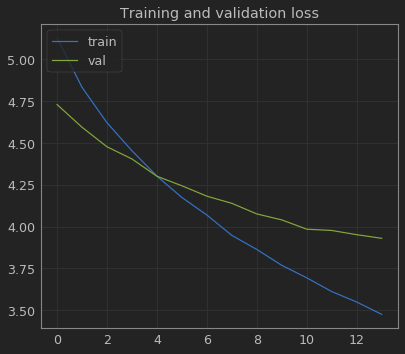

In [23]:
plot_training(history2)

In [129]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 120)               61560     
Total params: 4,256,376
Trainable params: 4,256,376
Non-trainable params: 0
_________________________________________________________________


## Prediction

In [104]:
test_data = np.load('models/bottleneck_features_test.npy')
preds = model2.predict(test_data, verbose=1, batch_size=16)

df_train = pd.read_csv('labels.csv')
df_test = pd.read_csv('sample_submission.csv')
one_hot = pd.get_dummies(df_train['breed'], sparse = True)

sub = pd.DataFrame(preds)
sub.columns = one_hot.columns.values
sub.insert(0, 'id', df_test['id'])

sub.to_csv('sub.csv', index=False)

10357/10357 [==============================] - 5s 501us/step
